In [1]:
import seaborn as sns 
import pandas as pd 
import numpy as np
import matplotlib as plt
import math

In [2]:
movements = pd.read_csv('../data/data_movements_7.csv')
trials = pd.read_csv('../data/data_trials_7.csv')
trials['trial'] = trials.trial - 1

In [3]:
df = movements[['x', 'y', 'time', 'trial', 'state']]

# Desired timestamp granularity
timestamp_granularity = 0.001

# Create an empty list to store interpolated dataframes
interpolated_dfs = []

# Iterate through the rows of the original DataFrame
for i in range(len(df) - 1):
    # Extract data from the current and next rows
    current_row = df.iloc[i]
    next_row = df.iloc[i + 1]

    # Calculate the time points for interpolation
    t1 = current_row["time"]
    t2 = next_row["time"]

    # Calculate the number of points to interpolate between t1 and t2
    num_points = int((t2 - t1) / timestamp_granularity)

    # Create an array of interpolated time points
    interpolated_times = np.linspace(t1, t2, num_points + 1)

    # Perform linear interpolation for 'x' and 'y' columns
    interpolated_x = np.interp(interpolated_times, [t1, t2], [current_row["x"], next_row["x"]])
    interpolated_y = np.interp(interpolated_times, [t1, t2], [current_row["y"], next_row["y"]])

    # Create a new DataFrame for this segment of interpolation
    interpolated_segment = pd.DataFrame({
        "x": interpolated_x,
        "y": interpolated_y,
        "time": interpolated_times,
        "trial": [current_row["trial"]] * (num_points + 1),  # Include trial number
        "state": [current_row["state"]] * (num_points + 1)  # Include state
    })

    # Append the interpolated segment to the list
    interpolated_dfs.append(interpolated_segment)

# Concatenate all interpolated segments into one DataFrame
interpolated_df = pd.concat(interpolated_dfs, ignore_index=True)

# Print the interpolated DataFrame
interpolated_df


,x,y,time,trial,state
0,1.872287,9.652317,0.007132,0,search_ring
1,1.872287,9.652314,0.008134,0,search_ring
2,1.872286,9.652310,0.009136,0,search_ring
3,1.872286,9.652307,0.010139,0,search_ring
4,1.872286,9.652303,0.011141,0,search_ring
...,...,...,...,...,...
1394782,-0.622505,2.241663,1357.001888,299,iti
1394783,-0.620690,2.236923,1357.002944,299,iti
1394784,-0.618875,2.232183,1357.004000,299,iti
1394785,-0.617060,2.227444,1357.005056,299,iti


<Axes: xlabel='x', ylabel='y'>

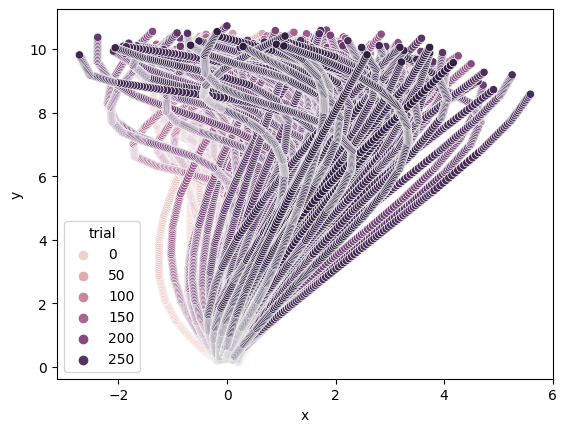

In [4]:
sns.scatterplot(data = interpolated_df.loc[interpolated_df.state == 'reach'], x = 'x', y = 'y', hue = 'trial')

In [5]:
# velocity is the change in distance over the change in time

def euclid_dist(x1, x2, y1, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)


change_in_dist= [0]
for i in range(1, len(interpolated_df)):
    current_row = interpolated_df.iloc[i]
    previous_row = interpolated_df.iloc[i-1]
    change_in_dist.append(euclid_dist(previous_row.x, current_row.x, previous_row.y, current_row.y))

interpolated_df['change_in_dist'] = change_in_dist



In [6]:
# velocity is the change in distance over the change in time
velocity = interpolated_df.change_in_dist/0.001
interpolated_df['velocity'] = velocity

In [7]:
max_vel_df = interpolated_df.loc[interpolated_df.state == 'reach'].groupby('trial').agg({'velocity': 'max'}).reset_index()
max_vel_df = max_vel_df.rename(columns={'velocity': 'max_vel'})
max_vel_df

,trial,max_vel
0,0,28.610673
1,1,32.826411
2,2,35.101355
3,3,62.566180
4,4,45.375661
...,...,...
295,295,63.927263
296,296,65.027679
297,297,49.113648
298,298,55.650403


In [8]:
joined = pd.merge(interpolated_df, max_vel_df, on = 'trial', how = 'left')

In [9]:
initial_vector = joined.loc[(joined.state == 'reach') & (joined.velocity == joined.max_vel)].copy()
min_time = initial_vector.groupby('trial').agg({'time':'min'}).reset_index().rename(columns={'time': 'min_time'})
initial_vector = pd.merge(initial_vector, min_time, on='trial', how='left')
initial_vector = initial_vector.loc[initial_vector.time == initial_vector.min_time]
initial_vector

,x,y,time,trial,state,change_in_dist,velocity,max_vel,min_time
0,0.213678,8.247730,8.299593,0,reach,0.028611,28.610673,28.610673,8.299593
2,-0.113121,7.658705,18.363459,1,reach,0.032826,32.826411,32.826411,18.363459
5,0.021774,4.461463,24.183621,2,reach,0.035101,35.101355,35.101355,24.183621
7,-0.387334,3.747390,29.178645,3,reach,0.062566,62.566180,62.566180,29.178645
16,-0.143401,2.538414,33.728815,4,reach,0.045376,45.375661,45.375661,33.728815
...,...,...,...,...,...,...,...,...,...
1065,1.055808,5.152035,1338.822903,295,reach,0.063927,63.927263,63.927263,1338.822903
1066,1.460783,5.320709,1342.431449,296,reach,0.065028,65.027679,65.027679,1342.431449
1068,1.759005,7.702789,1347.515646,297,reach,0.049114,49.113648,49.113648,1347.515646
1069,2.099868,4.010202,1351.157259,298,reach,0.055650,55.650403,55.650403,1351.157259


In [10]:
# convert x, y coordinates for 'reach' to polar and add these to the data as columns 
# function inspired from https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates 
def cart2pol(x, y):
    r = []
    theta = []
    for i in range(len(x)): 
        r.append(np.sqrt((x[i])**2 + (y[i])**2))
        theta.append(np.arctan2(y[i], x[i]))
    return(r, theta)


reach_x = initial_vector.x.values
reach_y  = initial_vector.y.values

r, theta = cart2pol(reach_x, reach_y)

initial_vector['r'] = r 
initial_vector['theta'] = theta

In [11]:
initial_vector

,x,y,time,trial,state,change_in_dist,velocity,max_vel,min_time,r,theta
0,0.213678,8.247730,8.299593,0,reach,0.028611,28.610673,28.610673,8.299593,8.250497,1.544895
2,-0.113121,7.658705,18.363459,1,reach,0.032826,32.826411,32.826411,18.363459,7.659541,1.585566
5,0.021774,4.461463,24.183621,2,reach,0.035101,35.101355,35.101355,24.183621,4.461516,1.565916
7,-0.387334,3.747390,29.178645,3,reach,0.062566,62.566180,62.566180,29.178645,3.767355,1.673792
16,-0.143401,2.538414,33.728815,4,reach,0.045376,45.375661,45.375661,33.728815,2.542461,1.627229
...,...,...,...,...,...,...,...,...,...,...,...
1065,1.055808,5.152035,1338.822903,295,reach,0.063927,63.927263,63.927263,1338.822903,5.259106,1.368665
1066,1.460783,5.320709,1342.431449,296,reach,0.065028,65.027679,65.027679,1342.431449,5.517593,1.302852
1068,1.759005,7.702789,1347.515646,297,reach,0.049114,49.113648,49.113648,1347.515646,7.901080,1.346287
1069,2.099868,4.010202,1351.157259,298,reach,0.055650,55.650403,55.650403,1351.157259,4.526717,1.088423


In [12]:
plot_data = pd.merge(initial_vector, trials, on = 'trial', how = 'left')

In [13]:
previous_uncertainty = ['baseline_no_uncertainty'] * 21
columns_to_iterate = ['cursor_vis', 'no_uncertainty', 'low_uncertainty', 'high_uncertainty', 'unlimited_uncertainty']

for i in range(21, len(plot_data) - 99):
    prev_row = plot_data.iloc[i - 1]
    if prev_row.no_uncertainty == True:
        previous_uncertainty.append('no_uncertainty')
    elif prev_row.low_uncertainty == True: 
        previous_uncertainty.append('low_uncertainty')
    elif prev_row.high_uncertainty == True: 
        previous_uncertainty.append('high_uncertainty')
    elif prev_row.unlimited_uncertainty == True: 
        previous_uncertainty.append('unlimited_uncertainty')
    else: 
        previous_uncertainty.append('unlimited_uncertainty')

previous_uncertainty += ['washout_unlimited_uncertainty'] * (300 - len(previous_uncertainty))
plot_data['previous_uncertainty'] = previous_uncertainty

In [14]:
plot_data

,x,y,time,trial,state,change_in_dist,velocity,max_vel,min_time,r,...,cycle,target_angle,no_uncertainty,low_uncertainty,high_uncertainty,unlimited_uncertainty,endpoint_theta,movement_time,movement_initiation_time,previous_uncertainty
0,0.213678,8.247730,8.299593,0,reach,0.028611,28.610673,28.610673,8.299593,8.250497,...,0,90,0.0,0.0,0.0,0.0,87.487341,0.481953,0.334215,baseline_no_uncertainty
1,-0.113121,7.658705,18.363459,1,reach,0.032826,32.826411,32.826411,18.363459,7.659541,...,1,90,0.0,0.0,0.0,0.0,90.029498,0.432963,0.283207,baseline_no_uncertainty
2,0.021774,4.461463,24.183621,2,reach,0.035101,35.101355,35.101355,24.183621,4.461516,...,2,90,0.0,0.0,0.0,0.0,88.190232,0.832960,0.350231,baseline_no_uncertainty
3,-0.387334,3.747390,29.178645,3,reach,0.062566,62.566180,62.566180,29.178645,3.767355,...,3,90,0.0,0.0,0.0,0.0,90.216803,0.634981,0.282232,baseline_no_uncertainty
4,-0.143401,2.538414,33.728815,4,reach,0.045376,45.375661,45.375661,33.728815,2.542461,...,4,90,0.0,0.0,0.0,0.0,85.711819,0.483127,0.267209,baseline_no_uncertainty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.055808,5.152035,1338.822903,295,reach,0.063927,63.927263,63.927263,1338.822903,5.259106,...,295,90,0.0,0.0,0.0,0.0,83.880906,0.266698,0.333339,washout_unlimited_uncertainty
296,1.460783,5.320709,1342.431449,296,reach,0.065028,65.027679,65.027679,1342.431449,5.517593,...,296,90,0.0,0.0,0.0,0.0,88.317330,0.265797,0.334161,washout_unlimited_uncertainty
297,1.759005,7.702789,1347.515646,297,reach,0.049114,49.113648,49.113648,1347.515646,7.901080,...,297,90,0.0,0.0,0.0,0.0,84.882262,0.316903,0.316217,washout_unlimited_uncertainty
298,2.099868,4.010202,1351.157259,298,reach,0.055650,55.650403,55.650403,1351.157259,4.526717,...,298,90,0.0,0.0,0.0,0.0,84.078377,0.266795,0.383227,washout_unlimited_uncertainty


<Axes: xlabel='trial', ylabel='theta'>

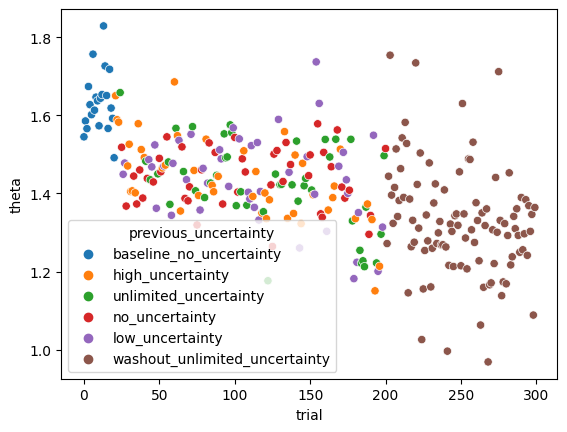

In [16]:
sns.scatterplot(data = plot_data, x = 'trial', y = 'theta', hue = 'previous_uncertainty')